### Libraries

In [193]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import itertools


#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}

In [194]:
def plotDatasetSplit(X_train_dates, X_test_dates, y_train, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.write_image("../results/dataset_split.png", width=1000, scale=2, format="png")
    fig.show()

In [195]:
def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [196]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)

    mae_ref = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)

        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(np.exp(y_test), np.exp(y_pred_permuted))

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

In [197]:
def addNLags(df, lags_list):
    lag_df= df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 24).fillna(0)

    return lag_df.fillna(0)

In [198]:
def normalizeData(data):
    df = data.copy()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

## Machine Learning Models

### Split Dataset

In [199]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.reset_index(inplace=True)
dates = df["Date"]
dates = pd.to_datetime(dates)

df = df.drop(columns=["Date"], axis=1)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
df.columns

Total Lags: 12046
Training Size:9637
Test Size: 2410


Index(['temperature_2m_C', 'relative_humidity_2m_%', 'dew_point_2m_C',
       'apparent_temperature_C', 'pressure_msl_hPa', 'surface_pressure_hPa',
       'cloud_cover_%', 'cloud_cover_high_%', 'et0_fao_evapotranspiration_mm',
       'vapour_pressure_deficit_kPa', 'wind_speed_10m_km/h',
       'wind_direction_10m_º', 'wind_gusts_10m', 'is_day',
       'sunshine_duration_sec', 'shortwave_radiation_W/m2',
       'direct_radiation_W/m2', 'diffuse_radiation_W/m2',
       'direct_normal_irradiance_W/m2', 'global_tilted_irradiance_W/m2',
       'terrestrial_radiation_W/m2', 'Temp_interna_Modulo_C', 'Demanda_kWh',
       'Year', 'Month', 'Hour', 'DayOfWeek', 'DayOfYear', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'isHoliday',
       'temp_cluster', 'Season'],
      dtype='object')

In [200]:
plotDatasetSplit(X_train_dates, X_test_dates, y_train, y_test)

### List of Models to Test

In [201]:
models, models_names = [], []

#Tree Models
for n in [1000]:
    LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=n, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
    XGB = XGBRegressor(n_estimators=n, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
    GBM = GradientBoostingRegressor(n_estimators=n, learning_rate=0.01, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    
for n in [3, 5, 15]:
    KNN = KNeighborsRegressor(n_neighbors=n, weights='uniform')
    models.append(KNN)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')

### Benchmark Transformations

In [202]:
def inverse_boxcox(y, lambda_):
    if lambda_ != 0:
        return np.exp(np.log(y * lambda_ + 1) / lambda_)
    else:
        return np.exp(y)

def benchmarkTransformations(models, models_names, X, y, trainingSize):
    results = pd.DataFrame(columns=["Model", "RMSE", "MAE", "RMSE_Log", "MAE_Log", "RMSE Boxcox", "MAE Boxcox"])
    log_models, boxcox_models = models.copy(), models.copy()
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_train, y_train = X.iloc[:trainingSize, :].copy(), y.iloc[:trainingSize].copy()
        X_test, y_test = X.iloc[trainingSize:, :].copy(), y.iloc[trainingSize:].copy()
        
        if "KNN" in model_name:
            X_train = normalizeData(X_train)
            X_test = normalizeData(X_test)
            
        # No transformation
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        
        # Logaritmic Transformation
        log_model = model
        log_model.fit(X_train, np.log1p(y_train))
        y_log_pred = log_model.predict(X_test)
        y_log_pred = np.expm1(y_log_pred)
        mae_log = mean_absolute_error(y_test, y_log_pred)
        rmse_log = root_mean_squared_error(y_test, y_log_pred)

        # Box-Cox Transformation
        y_train_boxcox, lambda_optima = boxcox(y_train)
        boxcox_model = model 
        boxcox_model.fit(X_train, y_train_boxcox)
        y_bc_pred = boxcox_model.predict(X_test)
        y_bc_pred = inverse_boxcox(y_bc_pred, lambda_optima)
        mae_boxcox = mean_absolute_error(y_test, y_bc_pred)
        rmse_boxcox = root_mean_squared_error(y_test, y_bc_pred)

        results.loc[len(results.index)] = [model_name, rmse, mae, rmse_log, mae_log, rmse_boxcox, mae_boxcox]
        
    return results

In [203]:
benchmark = benchmarkTransformations(models, models_names, X, y, trainingSize)
benchmark.to_csv("../results/benchmark_transformations.csv")
benchmark = benchmark.to_markdown(index=False)
print(benchmark)

100%|██████████| 5/5 [00:07<00:00,  1.55s/it]

| Model           |    RMSE |     MAE |   RMSE_Log |   MAE_Log |   RMSE Boxcox |   MAE Boxcox |
|:----------------|--------:|--------:|-----------:|----------:|--------------:|-------------:|
| LGBM_1000       | 3.1243  | 1.68245 |    3.15898 |   1.52202 |       3.29516 |      1.49227 |
| XGB_1000        | 3.11171 | 1.76335 |    3.19121 |   1.59486 |       3.39034 |      1.55135 |
| KNNr_3_uniform  | 4.23349 | 2.32677 |    4.01541 |   2.16801 |       3.93577 |      2.061   |
| KNNr_5_uniform  | 4.05878 | 2.32598 |    3.76529 |   2.08588 |       3.68557 |      1.93924 |
| KNNr_15_uniform | 3.7533  | 2.24113 |    3.54503 |   1.95238 |       3.57648 |      1.83559 |


### Lags as Predictors

In [204]:
def gridSearchLags(dataframe, lags_combinations):
    df = dataframe.copy(deep=True)
    y = df["Demanda_kWh"]
    X = df.drop(columns=["Demanda_kWh"], axis=1)
    X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
    X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()
    results = pd.DataFrame(columns=["Lags", "MAE_Test", "RMSE_Test"])
    model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    results.loc[len(results.index)] = [[0], mae, rmse]

    for lags in tqdm(lags_combinations, total=len(lags_combinations)):
        df = dataframe.copy(deep=True)
        df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"])
        df = addNLags(df, lags)
        y = df["Demanda_kWh"]
        X = df.drop(columns=["Demanda_kWh"], axis=1)
        X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
        X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()
        model = XGBRegressor(n_estimators=1300, random_state=123, learning_rate=0.01, max_depth=5, verbose=0)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
        rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
        results.loc[len(results.index)] = [lags, mae, rmse]

    best_mae_index = results["MAE_Test"].idxmin()
    best_rmse_index = results["RMSE_Test"].idxmin()

    best_mae_lags = results.loc[best_mae_index, "Lags"]
    best_rmse_lags = results.loc[best_rmse_index, "Lags"]

    print(f"Mejor combinación de lags basada en MAE: {best_mae_lags} con MAE: {results.loc[best_mae_index, 'MAE_Test']}")
    print(f"Mejor combinación de lags basada en RMSE: {best_rmse_lags} con RMSE: {results.loc[best_rmse_index, 'RMSE_Test']}")

    return results, best_mae_lags

In [205]:
lags_combinations = []
possible_lags = [1, 2, 3]

for i in range(1, len(possible_lags) + 1):
    lags_combinations.extend(itertools.combinations(possible_lags, i))
lags_combinations = [list(combo) for combo in lags_combinations]

In [206]:
results, best_lags_comb = gridSearchLags(df, lags_combinations)
results = results.to_markdown(index=False)
print(results)

100%|██████████| 7/7 [00:22<00:00,  3.26s/it]

Mejor combinación de lags basada en MAE: [1, 3] con MAE: 1.4845735780830605
Mejor combinación de lags basada en RMSE: [1] con RMSE: 3.0472298542898884
| Lags      |   MAE_Test |   RMSE_Test |
|:----------|-----------:|------------:|
| [0]       |    1.76576 |     3.1114  |
| [1]       |    1.49634 |     3.04723 |
| [2]       |    1.5409  |     3.17718 |
| [3]       |    1.57006 |     3.20099 |
| [1, 2]    |    1.48749 |     3.04768 |
| [1, 3]    |    1.48457 |     3.07657 |
| [2, 3]    |    1.52875 |     3.15131 |
| [1, 2, 3] |    1.49837 |     3.08534 |


In [207]:
best_lags_comb

[1, 3]

In [208]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df.resample('1H').mean()
df.reset_index(inplace=True)
dates = df["Date"]
dates = pd.to_datetime(dates)
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
df = addNLags(df, best_lags_comb)
df = df.drop(columns=["Date"], axis=1)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Year"], axis=1)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
col_names = list(X.columns)

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
df.columns

Total Lags: 12385
Training Size:9909
Test Size: 2477


Index(['temperature_2m_C', 'relative_humidity_2m_%', 'dew_point_2m_C',
       'apparent_temperature_C', 'pressure_msl_hPa', 'surface_pressure_hPa',
       'cloud_cover_%', 'cloud_cover_high_%', 'et0_fao_evapotranspiration_mm',
       'vapour_pressure_deficit_kPa', 'wind_speed_10m_km/h',
       'wind_direction_10m_º', 'wind_gusts_10m', 'is_day',
       'sunshine_duration_sec', 'shortwave_radiation_W/m2',
       'direct_radiation_W/m2', 'diffuse_radiation_W/m2',
       'direct_normal_irradiance_W/m2', 'global_tilted_irradiance_W/m2',
       'terrestrial_radiation_W/m2', 'Temp_interna_Modulo_C', 'Demanda_kWh',
       'Year', 'Month', 'Hour', 'DayOfWeek', 'DayOfYear', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'isHoliday',
       'temp_cluster', 'Season', 'lag_1', 'lag_3'],
      dtype='object')

### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


 20%|██        | 1/5 [00:05<00:21,  5.38s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.5073960502595425, RMSE: 3.1681541376630187


 40%|████      | 2/5 [00:10<00:15,  5.11s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.5264183926120942, RMSE: 3.2188829255709437


 60%|██████    | 3/5 [00:10<00:06,  3.04s/it]

Model: KNNr_3_uniform ===> Mean Test MAE: 1.7784886241406435, RMSE: 3.5822439313454884


 80%|████████  | 4/5 [00:11<00:02,  2.04s/it]

Model: KNNr_5_uniform ===> Mean Test MAE: 1.695703021673124, RMSE: 3.4159793078237968


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

Model: KNNr_15_uniform ===> Mean Test MAE: 1.6625946538334047, RMSE: 3.379048844410319


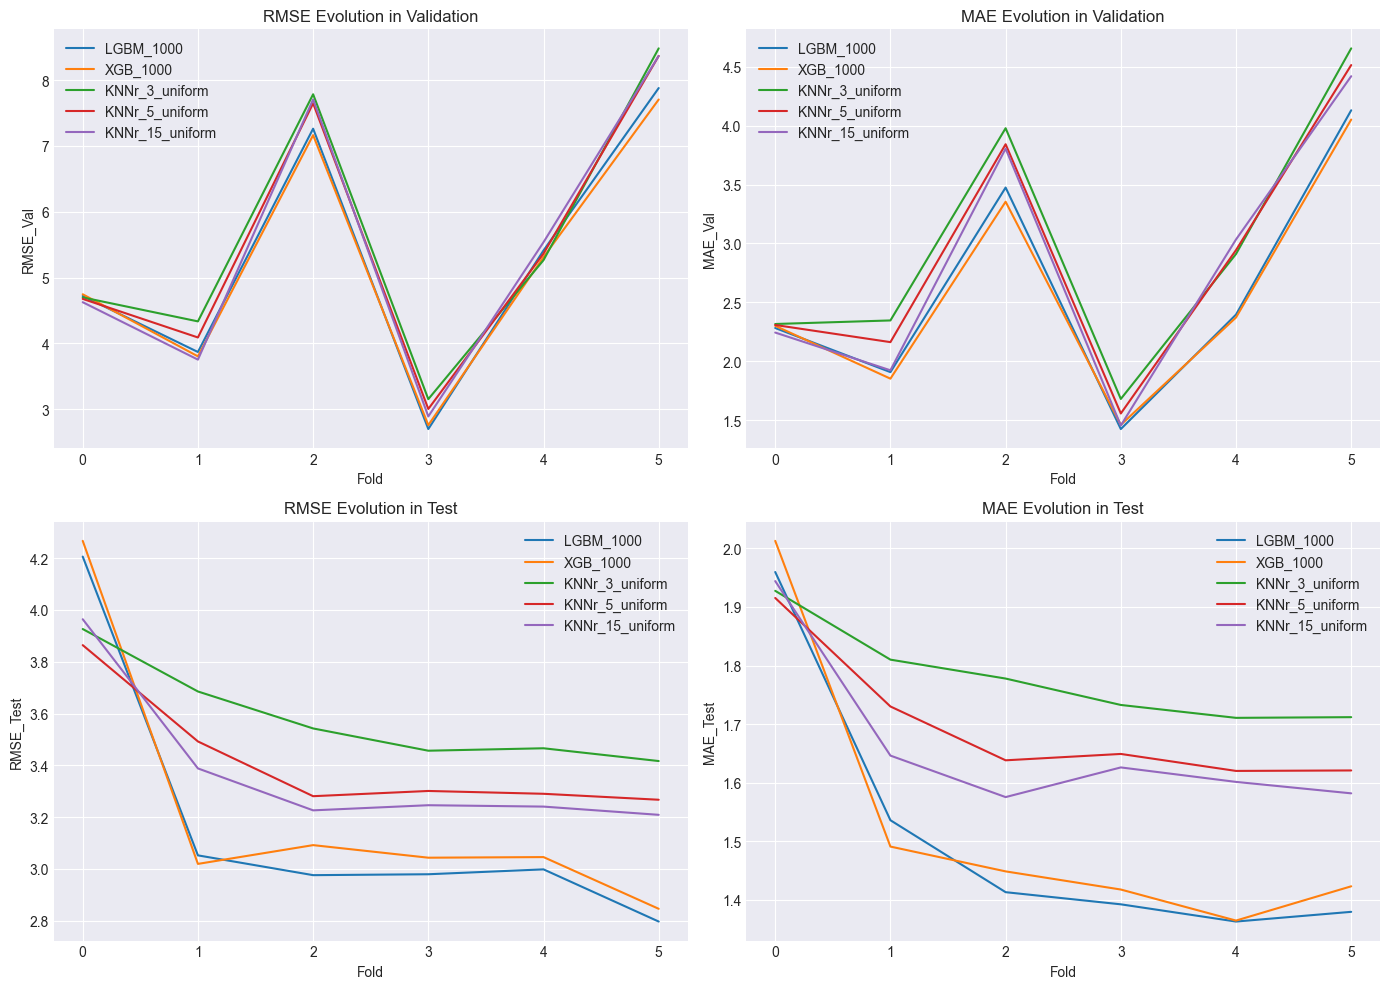

In [209]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])

    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_test2 = X_test.copy()
        X2 = X.copy()
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X2)):
            X_train, X_val = X2[train_index], X2[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            if "KNN" in model_name:
                X_train = normalizeData(X_train)
                X_val = normalizeData(X_val)
                X_test2 = normalizeData(X_test2)
            model.fit(X_train, y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            mae_val.append(mean_absolute_error(np.exp(y_val), np.exp(y_pred_val)))
            rmse_val.append(root_mean_squared_error(np.exp(y_val), np.exp(y_pred_val)))
            
            #Test Scores
            y_pred_test = model.predict(X_test2)
            mae_test.append(mean_absolute_error(np.exp(y_test), np.exp(y_pred_test)))
            rmse_test.append(root_mean_squared_error(np.exp(y_test), np.exp(y_pred_test)))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_plot.png')
        else:
            plt.savefig('../results/Walking_Forward_Validation_plot.png')
        plt.tight_layout()
        plt.show()
    return results

results = walkForwardValidation(X_train.to_numpy(), y_train.to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)

### Sliding Window Validation

<div align="center">
    <img src="https://i.sstatic.net/QNlQl.png" width=600px>
</div>

 20%|██        | 1/5 [00:04<00:18,  4.56s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.9594663776850005, RMSE: 3.7839080289757976


 40%|████      | 2/5 [00:09<00:13,  4.67s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.9195292689887322, RMSE: 3.727222558782774


 60%|██████    | 3/5 [00:09<00:05,  2.72s/it]

Model: KNNr_3_uniform ===> Mean Test MAE: 2.284777157426419, RMSE: 4.221218618999955


 80%|████████  | 4/5 [00:10<00:01,  1.83s/it]

Model: KNNr_5_uniform ===> Mean Test MAE: 2.194871667099913, RMSE: 3.99307351669557


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]

Model: KNNr_15_uniform ===> Mean Test MAE: 2.082382635882033, RMSE: 3.76015981564032


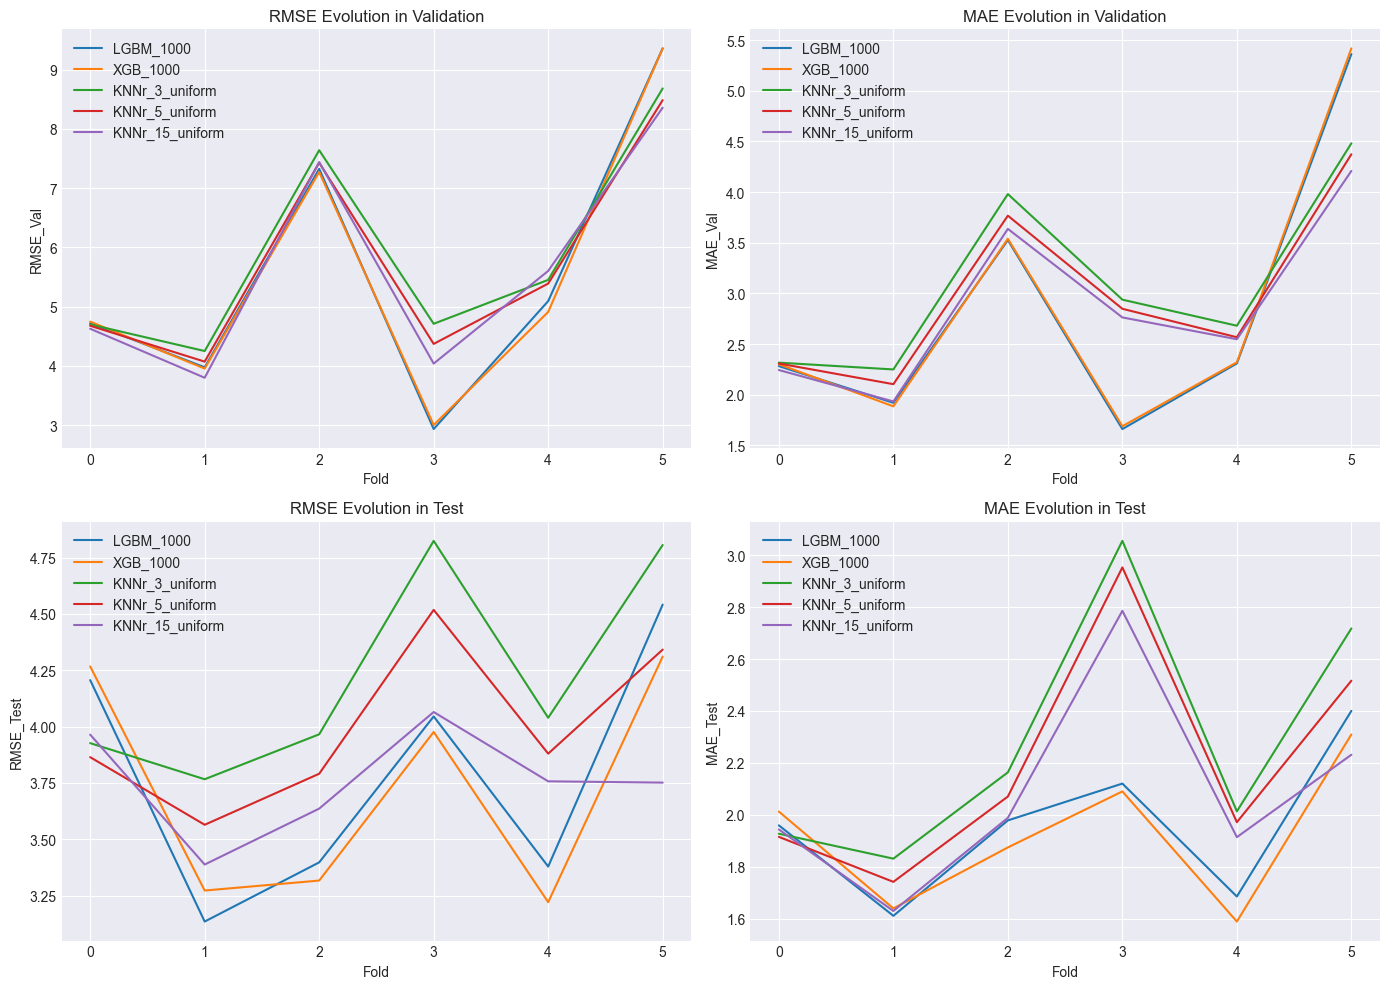

In [210]:
results = walkForwardValidation(X_train.to_numpy(), y_train.to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)


### Grid Search (XGBOOST)

In [211]:
paramsXGB = {
    'max_depth': [7, 8],
    'learning_rate': [0.005, 0.003],
    'gamma': [7, 8, 9],
    'colsample_bytree' : [0.7, 0.9, 1],
    'colsample_bynode': [ 0.7, 0.9, 1],
    'n_estimators': [1300]
}

def gridSearchXGB(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123)

        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    config["mae"] = best_mae
    return config

#gridSearchXGB(paramsXGB)

### Grid Search (LightGBM)

In [212]:
params = {
    'num_leaves': [10, 20, 30, 40],
    'learning_rate': [0.05, 0.01, 0.005],
    'colsample_bytree' : [0.7, 0.9, 1],
    'n_estimators': [1200],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
}

def gridSearchLGBM(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        n_estimators = param.get('n_estimators')
        num_leaves = param.get('num_leaves')
        lr = param.get('learning_rate')
        reg_alpha = param.get('reg_alpha')
        colsample_bytree = param.get('colsample_bytree')
        LGBMReg = LGBMRegressor(boosting_type='gbdt', n_estimators=n_estimators, learning_rate=lr, random_state=123, reg_alpha=reg_alpha, n_jobs=-1, verbose=-1, num_leaves=num_leaves) 
        LGBMReg.fit(
            X = X_train,
            y = y_train,
        )  
        y_pred = LGBMReg.predict(X_test)
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Num_leaves: {num_leaves}, Col_Sample_By_Tree: {colsample_bytree}, reg_alpha: {reg_alpha}")
    config["mae"] = best_mae
    return config
#gridSearchLGBM(params)

### Feature Importance 

In [213]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.005, max_depth=8, colsample_bytree = 1, colsample_bynode = 0.9, gamma=7, random_state=123)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f"MAE: {mae}, RMSE: {rmse}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.2879046547908837, RMSE: 3.064782541037053


,importance
temperature_2m_C,0.025974
lag_3,0.026745
diffuse_radiation_W/m2,0.029268
Month_cos,0.037177
Hour_sin,0.039067
shortwave_radiation_W/m2,0.039734
isHoliday,0.044644
Temp_interna_Modulo_C,0.046249
Year,0.048265
isWeekend,0.051410


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 45.70it/s]


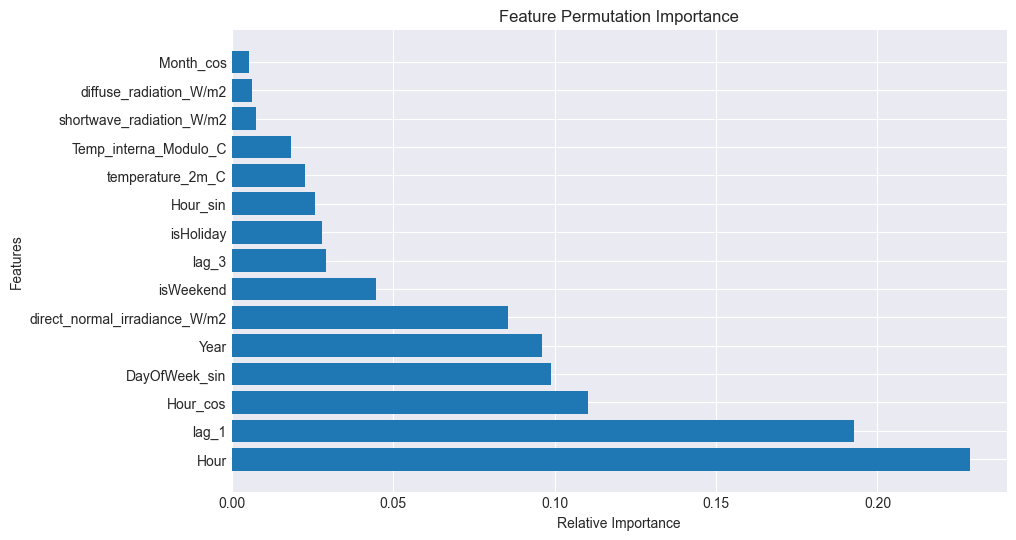

In [214]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test, np.array(col_names))

### Plot Prediction Results

In [215]:
plotPredictions(X_test_dates, np.exp(y_pred), np.exp(y_test), "predictions_Test_All")

In [216]:
plotPredictions(X_test_dates[:30*24], np.exp(y_pred[:30*24]), np.exp(y_test[:30*24]), "predictions_Test_Month")

In [217]:
plotPredictions(X_test_dates[:24*7], np.exp(y_pred[:24*7]), np.exp(y_test[:24*7]), "predictions_Test_Week")

In [218]:
print(f"Test Demand Min: {np.min(np.exp(y_test))} - Max: {np.max(np.exp(y_test))}")
print(f"Predicted Demand Min: {np.min(np.exp(y_pred))} - Max: {np.max(np.exp(y_pred))}")

Test Demand Min: 1.0 - Max: 46.0
Predicted Demand Min: 0.986118733882904 - Max: 18.050912857055664


### Final Results

In [219]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1400, learning_rate = 0.005, max_depth=7, colsample_bytree = 0.9, colsample_bynode = 0.9, gamma=7, random_state=123,  eval_metric='mae')

#Model with Validation Set
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    verbose=0
)
y_pred = regressorXGBR.predict(X_test)
print(f"With Validation set --> MAE: {mean_absolute_error(np.exp(y_test), np.exp(y_pred))}, RMSE: {root_mean_squared_error(np.exp(y_test), np.exp(y_pred))}")

With Validation set --> MAE: 1.2990206466333254, RMSE: 3.1105715231446394


In [230]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.reset_index(inplace=True)
dates = df["Date"]
dates = pd.to_datetime(dates)
y = df["Demanda_kWh"]  # +1 para asegurar valores positivos
y_boxcox, lambda_ = boxcox(y)
df.loc[y.index, "Demanda_kWh"] = y_boxcox

df = addNLags(df, [1,2])
df = df.drop(columns=["Date"], axis=1)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
col_names = list(X.columns)

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()
y_test = inverse_boxcox(y_test, lambda_)
X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:9637
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2'],
      dtype='object')

In [231]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.005, max_depth=8, colsample_bytree = 1, colsample_bynode = 0.9, gamma=7, random_state=123, eval_metric='mae')
regressorXGBR.fit(
    X = X_train,
    y = y_train
)

y_pred = regressorXGBR.predict(X_test)
y_pred = inverse_boxcox(y_pred, lambda_)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 1.343005433706146, RMSE: 3.1084523450637107


In [232]:
plotPredictions(X_test_dates, y_pred, y_test, "predictions_Test_All")

In [233]:
imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

,importance
temperature_2m_C,0.024393
diffuse_radiation_W/m2,0.034830
isHoliday,0.037418
Hour,0.040295
Month_cos,0.044369
isWeekend,0.049107
lag_2,0.050042
shortwave_radiation_W/m2,0.051138
Hour_sin,0.052731
direct_normal_irradiance_W/m2,0.054180
